In [1]:
# libraries imported
import os, cv2, itertools # cv2 -- OpenCV
import numpy as np 
import pandas as pd 
import keras
 
import matplotlib.pyplot as plt 
%matplotlib inline

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from random import shuffle
from IPython.display import display
from PIL import Image


Using TensorFlow backend.
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ktiwari\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [25]:
directory = 'C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/' # only have to change this path
TRAIN_DIR = directory+'images/'
TEST_DIR = directory+'predict_images/'
video_folder =directory+'videos/'
print(directory)
print(TRAIN_DIR)
print(TEST_DIR)
print(video_folder)



C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/
C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/images/
C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/predict_images/
C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/videos/


In [3]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

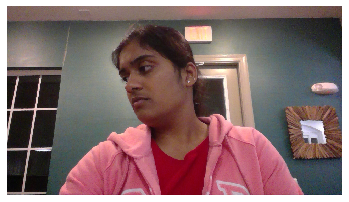

In [4]:
plt.imshow(plt.imread(np.random.choice(train_images)))
plt.axis('off')
plt.show()

In [5]:
# Shuffle all the images available in Training Directory before proceeding further
shuffle(os.listdir(TRAIN_DIR))

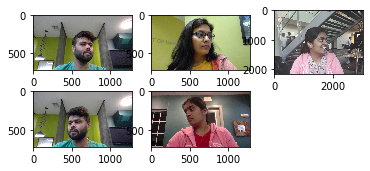

In [6]:
# plot suspicious photos from the suspicious vs clean dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = TRAIN_DIR
# plot first few images
for i in range(5):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'suspicious_110' + str(i+1) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

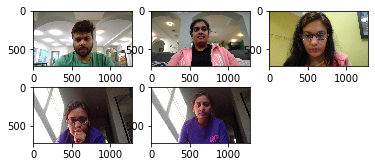

In [7]:
# plot clean photos from the suspicious vs clean dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = TRAIN_DIR
# plot first few images
for i in range(5):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'clean_11' + str(i+10) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [8]:
# load suspicious vs clean dataset, reshape and save to a new folder

from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = TRAIN_DIR
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('sus'):
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('photos.npy', photos)
save('labels.npy', labels)

(279, 200, 200, 3) (279,)


In [9]:
# load and confirm the shape
from numpy import load
photos = load('photos.npy')
labels = load('labels.npy')
print(photos.shape, labels.shape)

(279, 200, 200, 3) (279,)


In [10]:
# We will move the images based on the labels to their respective folders, so we will delete the existing directories if any
# and recreate them
from os import makedirs
from os import rmdir

import shutil

# delete directories
dataset_home = directory+'dataset_sus_vs_clean/'
if os.path.exists(dataset_home+'train/sus/'):
    shutil.rmtree(dataset_home+'train/sus/')
    shutil.rmtree(dataset_home+'train/clean/')
    shutil.rmtree(dataset_home+'valid/clean/')
    shutil.rmtree(dataset_home+'valid/sus/')
    shutil.rmtree(dataset_home)
    
# delete directory which has images extracted from videos
video_to_image_folder = directory+'video_to_image_folder/'
if os.path.exists(video_to_image_folder):
    shutil.rmtree(video_to_image_folder)
    

In [11]:
# organize dataset into a useful structure
from os import makedirs
from os import rmdir
from os import listdir
import shutil
from shutil import copyfile
from random import seed
from random import random
from random import shuffle
# create directories
dataset_home = directory+'dataset_sus_vs_clean/'
subdirs = ['train/', 'valid/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['sus/', 'clean/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=False)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = TRAIN_DIR
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'valid/'
    if file.startswith('sus'):
        dst = dataset_home + dst_dir + 'sus/'  + file
        copyfile(src, dst)
    elif file.startswith('clean'):
        dst = dataset_home + dst_dir + 'clean/'  + file
        copyfile(src, dst)

#       
video_to_image_folder = directory+'video_to_image_folder/'
newdir = video_to_image_folder
makedirs(newdir, exist_ok=False)
print(video_to_image_folder)

In [12]:
# kernel_initializer setup
xavier = keras.initializers.glorot_normal(seed=None)
he = keras.initializers.he_normal(seed=None)


model = Sequential()
# Convolutional layers and Pooling
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
       
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=he, padding='same' ))
model.add(MaxPooling2D((2, 2)))
    
model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer=he, padding='same' ))
model.add(MaxPooling2D((2, 2)))
    
model.add(Conv2D(55, (3, 3), activation='relu', kernel_initializer=xavier, padding='same' ))
model.add(MaxPooling2D((2, 2)))

# Flattening
model.add(Flatten())
model.add(Dropout(0.5)) 

# Dense layers using regularizer l2
model.add(Dense(128, activation='relu', kernel_initializer=he,kernel_regularizer=regularizers.l2(0.02)))

# Dense layers
model.add(Dense(200)) #64
model.add(Activation('relu')) 

model.add(Dense(1)) 
model.add(Activation('sigmoid')) 

# Model Summary
model.summary()

# Optimizer
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 40)        11560     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 40)        0         
________________________________________________

In [13]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  shear_range=0.15,
                                  zoom_range=0.2,
                                  rotation_range=45,
                                  #width_shift_range=[-0.2,0.2],
                                  #height_shift_range=0.25,
                                  brightness_range=[0.5,1.5],
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = train_datagen.flow_from_directory(directory+'dataset_sus_vs_clean/train/',
        class_mode='binary', batch_size=10, target_size=(200, 200))

val_it = val_datagen.flow_from_directory(directory+'dataset_sus_vs_clean/valid/',
        class_mode='binary', batch_size=5, target_size=(200, 200))
print(len(train_it)) # used in steps_per_epoch
print(len(val_it)) # used in validation_steps

Found 202 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
21
16


In [14]:
history = model.fit_generator( train_it,
                         steps_per_epoch=len(train_it),
                         epochs=150,
                         validation_data= val_it,
                         validation_steps= len(val_it))  



Instructions for updating:
Use tf.cast instead.
Epoch 1/150
21/21 [==============================] - 25s 1s/step - loss: 2.7061 - accuracy: 0.6287 - val_loss: 1.3356 - val_accuracy: 0.6623
Epoch 2/150
21/21 [==============================] - 21s 992ms/step - loss: 1.0659 - accuracy: 0.5941 - val_loss: 0.8900 - val_accuracy: 0.6623
Epoch 3/150
21/21 [==============================] - 21s 1s/step - loss: 0.7923 - accuracy: 0.6139 - val_loss: 0.8372 - val_accuracy: 0.6623
Epoch 4/150
21/21 [==============================] - 22s 1s/step - loss: 0.7366 - accuracy: 0.6139 - val_loss: 0.7198 - val_accuracy: 0.6364
Epoch 5/150
21/21 [==============================] - 22s 1s/step - loss: 0.7168 - accuracy: 0.6139 - val_loss: 0.7066 - val_accuracy: 0.6623
Epoch 6/150
21/21 [==============================] - 23s 1s/step - loss: 0.7313 - accuracy: 0.6188 - val_loss: 0.6945 - val_accuracy: 0.6623
Epoch 7/150
21/21 [==============================] - 20s 953ms/step - loss: 0.7164 - accuracy: 0.6040 -

21/21 [==============================] - 20s 961ms/step - loss: 0.5426 - accuracy: 0.8020 - val_loss: 1.0639 - val_accuracy: 0.7273
Epoch 57/150
21/21 [==============================] - 20s 973ms/step - loss: 0.5146 - accuracy: 0.8218 - val_loss: 0.3771 - val_accuracy: 0.8052
Epoch 58/150
21/21 [==============================] - 20s 957ms/step - loss: 0.5401 - accuracy: 0.7723 - val_loss: 1.2402 - val_accuracy: 0.7273
Epoch 59/150
21/21 [==============================] - 20s 964ms/step - loss: 0.5263 - accuracy: 0.8069 - val_loss: 1.8498 - val_accuracy: 0.8052
Epoch 60/150
21/21 [==============================] - 20s 966ms/step - loss: 0.6199 - accuracy: 0.7871 - val_loss: 1.5021 - val_accuracy: 0.7792
Epoch 61/150
21/21 [==============================] - 20s 966ms/step - loss: 0.4376 - accuracy: 0.8416 - val_loss: 0.1433 - val_accuracy: 0.7662
Epoch 62/150
21/21 [==============================] - 20s 967ms/step - loss: 0.5100 - accuracy: 0.7871 - val_loss: 0.3425 - val_accuracy: 0.792

21/21 [==============================] - 20s 976ms/step - loss: 0.3938 - accuracy: 0.8812 - val_loss: 0.2223 - val_accuracy: 0.8312
Epoch 113/150
21/21 [==============================] - 20s 958ms/step - loss: 0.3713 - accuracy: 0.8663 - val_loss: 1.3415 - val_accuracy: 0.8182
Epoch 114/150
21/21 [==============================] - 20s 967ms/step - loss: 0.3767 - accuracy: 0.8960 - val_loss: 0.7311 - val_accuracy: 0.7273
Epoch 115/150
21/21 [==============================] - 20s 950ms/step - loss: 0.4105 - accuracy: 0.8713 - val_loss: 0.3574 - val_accuracy: 0.8442
Epoch 116/150
21/21 [==============================] - 19s 917ms/step - loss: 0.3976 - accuracy: 0.8762 - val_loss: 0.2199 - val_accuracy: 0.8571
Epoch 117/150
21/21 [==============================] - 21s 984ms/step - loss: 0.3820 - accuracy: 0.8564 - val_loss: 0.6505 - val_accuracy: 0.8052
Epoch 118/150
21/21 [==============================] - 20s 943ms/step - loss: 0.4538 - accuracy: 0.8515 - val_loss: 0.3110 - val_accuracy:

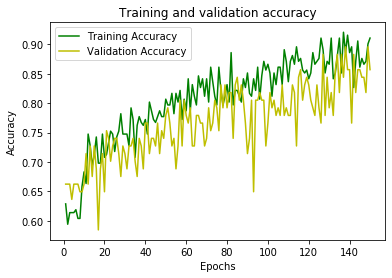

In [15]:
# for plotting the training and validation accuracy
plt.clf()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

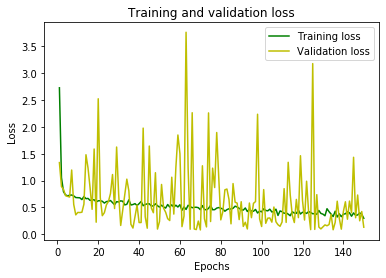

In [16]:
# for plotting the training and validation loss
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Load the data for making predictions
test_datagen = ImageDataGenerator(rescale = 1./255)
prediction_set = test_datagen.flow_from_directory(directory+'predict_images/', # relative path from working directoy
                                            target_size = (200, 200),batch_size=1,
                                            class_mode = 'binary')
predictions=model.predict(prediction_set)

Found 67 images belonging to 1 classes.


In [18]:
i=np.random.choice(len(predictions))

This image is predicted as Suspicious


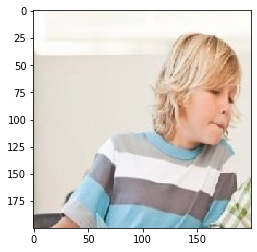

In [19]:
plt.imshow(prediction_set[i][0][0])
print("This image is predicted as","Suspicious" if predictions[i] > 0.5 else "Clean")

This image is predicted as Clean


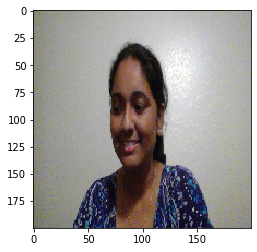

In [20]:
i1=np.random.choice(len(predictions))
plt.imshow(prediction_set[i1][0][0])
print("This image is predicted as","Suspicious" if predictions[i1] > 0.5 else "Clean")

This image is predicted as Clean


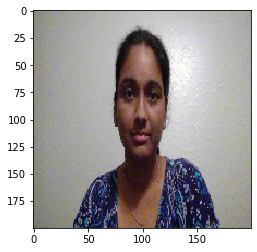

In [21]:
i1=np.random.choice(len(predictions))
plt.imshow(prediction_set[i1][0][0])
print("This image is predicted as","Suspicious" if predictions[i1] > 0.5 else "Clean")

In [22]:
# Predicting all images in the folder
for img in range(len(predictions)):
    print(prediction_set.filenames[img],predictions[img],"Suspicious" if predictions[img] > 0.5 else "Clean")
   

predict\image001.jpg [0.37183785] Clean
predict\image002.jpg [0.95387137] Suspicious
predict\image003.jpg [0.24325402] Clean
predict\image004.jpg [0.7553379] Suspicious
predict\image005.jpg [0.7919212] Suspicious
predict\image006.jpg [0.15524006] Clean
predict\image007.jpg [0.3384222] Clean
predict\image008.jpg [0.91752136] Suspicious
predict\image009.jpg [0.9557027] Suspicious
predict\image010.jpg [0.7841197] Suspicious
predict\image011.jpg [0.7203698] Suspicious
predict\image012.jpg [0.8498042] Suspicious
predict\image013.jpg [0.1461638] Clean
predict\image014.jpg [0.02723514] Clean
predict\image015.jpg [0.93443114] Suspicious
predict\image016.jpg [0.0030313] Clean
predict\image017.jpg [0.9456679] Suspicious
predict\image018.jpg [0.15699373] Clean
predict\image019.jpg [0.87823635] Suspicious
predict\image020.jpg [0.9541323] Suspicious
predict\image021.jpg [0.9240906] Suspicious
predict\image022.jpg [0.7460664] Suspicious
predict\image023.jpg [0.09276137] Clean
predict\image024.jpg [0

In [26]:
# function to create frames from .mp4 files
def getFrame(sec):  
    for filename in os.listdir(video_folder):
        hasFrames=False
        vidcap = cv2.VideoCapture(video_folder+filename)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            
            cv2.imwrite("image"+str(count)+".jpg", image)   
            im = Image.open("image"+str(count)+".jpg") 
            
            # maintaing the best possible quality for that size
            im.save(os.path.join(video_to_image_folder,filename.replace(".mp4","_")+str(count)+".jpg"),'JPEG',optimize=True)
      
    return hasFrames

In [29]:
# frame extraction
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)

# extraction of frames from videos happens in the below while loop
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

C:/Users/ktiwari/Documents/USF/Kirti/USF CourseWork/2nd Sem/DSP-6930/Project/video_to_image_folder/


In [30]:
from keras.preprocessing import image
prediction_dict={}


for video in os.listdir(video_folder):
    video=video.replace(".mp4","")
    images=os.listdir(video_to_image_folder)
    prediction_list=[]
    for image1 in images:
        if image1.startswith(video):
            full_image_path = video_to_image_folder+image1
            test_image = image.load_img(full_image_path,target_size=(200,200))
            test_image = image.img_to_array(test_image)
            test_image = np.expand_dims(test_image,axis=0)
            result = model.predict(test_image)
            train_it.class_indices
            if result[0][0]>=0.5:
                prediction = 'Suspicious'
            else:
                prediction = 'Clean'
            prediction_list.append(prediction)
            print(image1,prediction)
    predict_list_sus_count = prediction_list.count("Suspicious")
    total_count = len(prediction_list)
    suspicious_ratio = round((predict_list_sus_count/total_count),4)
    if(suspicious_ratio > 0.5):
        final_pred = 'Suspicious'
    else:
        final_pred = 'Clean'
    print("Summary: Suspicious_Count-",predict_list_sus_count,"Total_Count-", total_count, "Ratio-",suspicious_ratio,"Overall Prediction-",final_pred)
     
    prediction_dict[video]=prediction_list
            
#print(prediction_dict)


video002_1.jpg Clean
video002_10.jpg Clean
video002_11.jpg Clean
video002_12.jpg Clean
video002_13.jpg Clean
video002_14.jpg Clean
video002_2.jpg Clean
video002_3.jpg Clean
video002_4.jpg Clean
video002_5.jpg Clean
video002_6.jpg Clean
video002_7.jpg Clean
video002_8.jpg Clean
video002_9.jpg Clean
Summary: Suspicious_Count- 0 Total_Count- 14 Ratio- 0.0 Overall Prediction- Clean
video003_1.jpg Clean
video003_10.jpg Clean
video003_11.jpg Clean
video003_12.jpg Clean
video003_2.jpg Clean
video003_3.jpg Clean
video003_4.jpg Clean
video003_5.jpg Clean
video003_6.jpg Clean
video003_7.jpg Clean
video003_8.jpg Clean
video003_9.jpg Clean
Summary: Suspicious_Count- 0 Total_Count- 12 Ratio- 0.0 Overall Prediction- Clean
video004_1.jpg Suspicious
video004_10.jpg Suspicious
video004_11.jpg Suspicious
video004_2.jpg Suspicious
video004_3.jpg Suspicious
video004_4.jpg Suspicious
video004_5.jpg Suspicious
video004_6.jpg Suspicious
video004_7.jpg Suspicious
video004_8.jpg Suspicious
video004_9.jpg Suspi

Video028_8.jpg Clean
Video028_9.jpg Clean
Summary: Suspicious_Count- 4 Total_Count- 17 Ratio- 0.2353 Overall Prediction- Clean
Video029_1.jpg Suspicious
Video029_10.jpg Suspicious
Video029_2.jpg Suspicious
Video029_3.jpg Suspicious
Video029_4.jpg Suspicious
Video029_5.jpg Suspicious
Video029_6.jpg Suspicious
Video029_7.jpg Suspicious
Video029_8.jpg Suspicious
Video029_9.jpg Suspicious
Summary: Suspicious_Count- 10 Total_Count- 10 Ratio- 1.0 Overall Prediction- Suspicious
Video030_1.jpg Clean
Video030_10.jpg Clean
Video030_11.jpg Suspicious
Video030_12.jpg Suspicious
Video030_13.jpg Suspicious
Video030_14.jpg Suspicious
Video030_15.jpg Suspicious
Video030_16.jpg Suspicious
Video030_17.jpg Suspicious
Video030_2.jpg Clean
Video030_3.jpg Clean
Video030_4.jpg Clean
Video030_5.jpg Clean
Video030_6.jpg Clean
Video030_7.jpg Clean
Video030_8.jpg Clean
Video030_9.jpg Clean
Summary: Suspicious_Count- 7 Total_Count- 17 Ratio- 0.4118 Overall Prediction- Clean
video031_1.jpg Clean
video031_10.jpg Cl

video047_11.jpg Clean
video047_12.jpg Clean
video047_13.jpg Clean
video047_14.jpg Clean
video047_15.jpg Clean
video047_16.jpg Clean
video047_17.jpg Clean
video047_2.jpg Clean
video047_3.jpg Clean
video047_4.jpg Clean
video047_5.jpg Clean
video047_6.jpg Clean
video047_7.jpg Clean
video047_8.jpg Clean
video047_9.jpg Clean
Summary: Suspicious_Count- 0 Total_Count- 17 Ratio- 0.0 Overall Prediction- Clean
video048_1.jpg Clean
video048_10.jpg Clean
video048_11.jpg Clean
video048_12.jpg Suspicious
video048_13.jpg Suspicious
video048_14.jpg Suspicious
video048_15.jpg Suspicious
video048_16.jpg Suspicious
video048_17.jpg Suspicious
video048_18.jpg Clean
video048_19.jpg Clean
video048_2.jpg Clean
video048_20.jpg Clean
video048_3.jpg Clean
video048_4.jpg Clean
video048_5.jpg Clean
video048_6.jpg Suspicious
video048_7.jpg Suspicious
video048_8.jpg Suspicious
video048_9.jpg Suspicious
Summary: Suspicious_Count- 10 Total_Count- 20 Ratio- 0.5 Overall Prediction- Clean
